In [11]:
import sys
import numpy as np
import numba
sys.path.append('../lib')
import snelib19odp.blackbody as blackbody
import speclite
import speclite.filters
from astropy.table import Table
import astropy.units as u
import matplotlib.pyplot as plt
from astropy.cosmology import Planck15 as cosmology

In [31]:
# ZTF filters
def load_filter(inst, band):
    data = Table.read('../const/filters/%s.%s.dat' % (inst, band), format='ascii')
    wave = []
    transmission = []
    for entry in data:
        if len(wave) > 0 and wave[-1] == entry['col1']:
            continue
        wave.append(entry['col1'])
        if entry['col2'] < 0.01 or entry['col1'] < 3790:
            transmission.append(0.0)
        else:
            transmission.append(entry['col2'])
    wave = np.array(wave)*u.Angstrom
    transmission = np.array(transmission)

    f = speclite.filters.FilterResponse(wavelength=wave, response=transmission, meta=dict(group_name='ZTF', band_name=band))
    #print(f)
    return f


FILTERS = {
    'ZTF_g': load_filter('Palomar_ZTF', 'g'),
    'ZTF_r': load_filter('Palomar_ZTF', 'r'),
    'ZTF_i': load_filter('Palomar_ZTF', 'i')
}

In [29]:
redshift = 0.014353
dist = cosmology.luminosity_distance(redshift).to(u.pc).value
dist_mod = 5*np.log10(dist) - 5
distance_cm = cosmology.luminosity_distance(redshift).to(u.cm).value

Text(0, 0.5, 'Temperature [eV]')

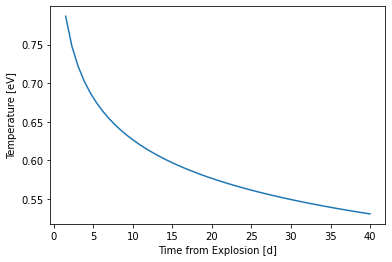

In [42]:
k_b = 8.617e-5 # eV/K

t = np.linspace(1.5, 40)*24*3600
t5 = t/1e5
r_pro12 = 1
#tph = 1.5*1*1*r_pro12**0.19 * t5**(-0.35)
tph = 1.07 * (t/1e4)**(-0.12)
plt.plot(t/24/3600, tph)

plt.xlabel('Time from Explosion [d]')
plt.ylabel('Temperature [eV]')

In [43]:
mags = {}
wavs = np.linspace(3000, 1e4)
for band in 'gri':
    mags[band] = np.empty(len(t))
    for i,temp in enumerate(tph):
        sed = blackbody.bb(temp/k_b, 4*np.pi**2*1e22, wavs)
        mags[band][i] = FILTERS['ZTF_%s' % band].get_ab_magnitude(sed/4/np.pi/distance_cm**2, wavs)

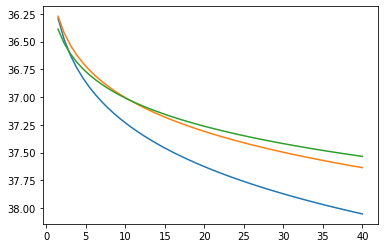

In [44]:
plt.plot(t/24/3600, mags['g'], label='g')
plt.plot(t/24/3600, mags['r'], label='r')
plt.plot(t/24/3600, mags['i'], label='i')
plt.gca().invert_yaxis()